# Compress and Decompress speech using the LPC method

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
import itertools as it

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [21]:
import wave
import struct

I'll have an object ComDec with all the audio parameters (WAV parameters, the windowing and overlap parameters, and the autocorrelation parameters), the input WAV data, the output WAV data, and the compressed data ($\alpha_i$'s, gain $G$, and fundamental frequency $F_1$).

In [22]:
class ComDec:
    """
    Variables:
    - Files
    self.input_filename
    self.input_file
    self.output_filename
    self.output_file
    
    - Parameters
    self.params
    self.window_size
    self.window_displacement
    self.overlap_size
    self.order
    self.min_fundamental_period
    self.max_fundamental_period
    self.num_windows
    
    - data
    self.input_data
    self.alphas
    self.gains
    self.voiced
    self.fundamentals
    self.output_data
    """
    
    def __init__(self, input_filename):
        self.input_filename = input_filename
        self.input_file = wave.open(self.input_filename, 'r')
        self.params = self.input_file.getparams()
        nframes = self.input_file.getnframes()
        self.input_data = np.empty(nframes)
        for f in range(nframes):
            amplitude = self.input_file.readframes(1)
            self.input_data[f] = struct.unpack('=h', amplitude)[0]
        
    ### Files
        
    def define_output(self, output_filename):
        self.output_filename = output_filename
        self.output_file = wave.open(self.output_filename, 'w')
        self.output_file.setparams(self.params)
        
    def write_output(self):
        # self.params[3] is nframes
        for i in range(0, self.params[3]):
            self.output_file.writeframes(struct.pack('=h', int(self.output_data[i])))
    
    # Params are (window_size, window_displacement, order, min_fundamental_period,
    # max_fundamental_period).
    # (window_size - window_displacement) assumed to be even.
    def define_compression_params(self, window_size=240, window_displacement=160, order=20,
                                 min_fundamental_period=20, max_fundamental_period=150):
        self.window_size = window_size
        self.window_displacement = window_displacement
        self.overlap_size = (self.window_size - self.window_displacement)
        self.order = order
        self.min_fundamental_period = min_fundamental_period
        self.max_fundamental_period = max_fundamental_period
        self.num_windows = self.input_file.getnframes() / self.window_displacement - 1
        
        self.alphas = np.zeros((self.num_windows, self.order))
        self.gains = np.zeros(self.num_windows)
        self.voiced = [None] * self.num_windows
        self.fundamentals = np.zeros(self.num_windows, dtype=int)
        
    ### Auxiliary functions
        
    def get_window(self, window_number):
        start_window = self.window_displacement * window_number
        end_window = start_window + self.window_size
        return self.input_data[start_window:end_window]
    
    ### Compression
    
    def compress(self):
        for window_number in range(self.num_windows):
            self.compress_window(window_number)
    
    def compress_window(self, window_number):
        window = self.get_window(window_number)
        R = self.get_R(window)
        alpha = self.get_alpha(R)
        self.alphas[window_number] = alpha
        self.gains[window_number] = self.get_gain(alpha, R)
        self.voiced[window_number] = self.get_voiced(R)
        self.fundamentals[window_number] = self.get_fundamental(R)
        
    def get_R(self, window):
        R = np.zeros(self.max_fundamental_period)
        for k in range(self.max_fundamental_period):
            for i in range(self.window_size - k):
                R[k] += window[i] * window[i + k]
        return R
    
    def get_alpha(self, R):
        R_matrix = np.empty((self.order, self.order))
        for k, l in it.product(range(self.order), repeat=2):
            R_matrix[k, l] = R[abs(k - l)]
        alpha = np.linalg.solve(R_matrix, R[1:self.order+1])
        return alpha
        
    def get_gain(self, alpha, R):
        gain = np.sqrt(R[0] - sum([alpha[k] * R[k + 1] for k in range(self.order)]))
        return gain
    
    def get_voiced(self, R):
        normalized_R = R[self.min_fundamental_period:]
        normalized_R = abs(normalized_R)
        normalized_R /= max(normalized_R)
        area = sum(normalized_R)
        return area < len(normalized_R) * 0.28
    
    def get_fundamental(self, R):
        return np.argmax(R[self.min_fundamental_period:]) + self.min_fundamental_period
        
    ### Decompression
    
    def decompress(self):
        self.decompressed_windows = np.empty((self.num_windows, self.window_size))
        excitation_position = 0
        for window_number in range(self.num_windows):
            self.decompressed_windows[window_number], next_excitation_position =\
                            self.decompressed_window(window_number, excitation_position)
            excitation_position = next_excitation_position
            #print 'next_excitation_position = {}'.format(next_excitation_position)
        self.merge_windows(self.decompressed_windows)
    
    def decompressed_window(self, window_number, excitation_position=0):
        extended_window, next_excitation_position =\
                        self.get_voiced_excitation(window_number, excitation_position)
        for i in range(self.order, len(extended_window)):
            extended_window[i] += sum([self.alphas[window_number, k]
                                       * extended_window[i - k - 1]
                                       for k in range(self.order)])
        return extended_window[8 * self.order:], next_excitation_position
        
    def get_voiced_excitation(self, window_number, excitation_position):
        extended_window = np.zeros(self.window_size + 8 * self.order)
        position = excitation_position + 8 * self.order
        while position >= 0:
            position -= self.fundamentals[window_number]
        position += self.fundamentals[window_number]
        while position < self.window_size + 8 * self.order:
            extended_window[position] = self.gains[window_number]
            position += self.fundamentals[window_number]
        return extended_window, (position - 8 * self.order) % (self.window_displacement)
    
    def merge_windows(self, windows):
        self.output_data = np.zeros(len(self.input_data))
        for window_number in range(self.num_windows):
            start_window = window_number * self.window_displacement
            for i in range(0, self.overlap_size):
                self.output_data[start_window + i] += windows[window_number, i] / 2.0
            for i in range(self.overlap_size, self.window_size - self.overlap_size):
                self.output_data[start_window + i] += windows[window_number, i]
            for i in range(self.window_size - self.overlap_size, self.window_size):
                self.output_data[start_window + i] += windows[window_number, i] / 2.0
            
    ### Close files
        
    def close_input(self):
        self.input_file.close()
        
    def close_output(self):
        self.output_file.close()

In [28]:
filename = 'demo'
my_ComDec = ComDec('wav_examples/{}.wav'.format(filename))

In [29]:
my_ComDec.define_compression_params(order=5)

In [30]:
my_ComDec.compress()

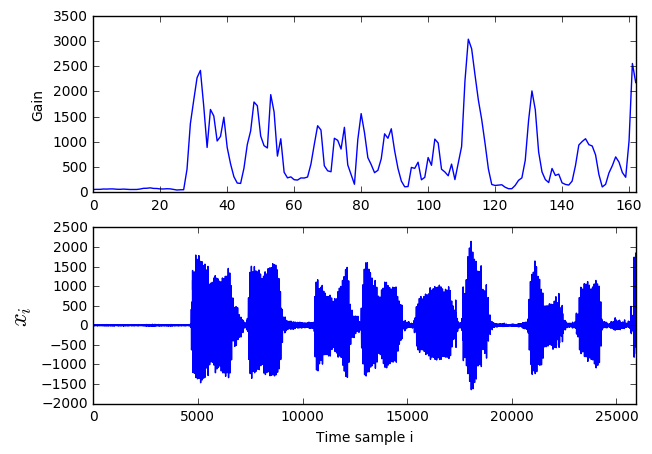

In [31]:
fig, ax = plt.subplots(2)
#ax[0].scatter(range(my_ComDec.num_windows), my_ComDec.voiced)
ax[0].plot(my_ComDec.gains)
ax[0].set_xlim(0, 162)
#ax[0].set_ylim(0, 150)
#ax[0].set_ylabel('Fundamental periods')
ax[0].set_ylabel('Gain')
#ax[0].set_xlabel('Window number')
#ax[0].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom='off',      # ticks along the bottom edge are off
#    top='off',         # ticks along the top edge are off
#    labelbottom='off')
ax[1].plot(my_ComDec.input_data)
ax[1].set_ylabel(r'$x_i$', fontsize='xx-large')
ax[1].set_xlabel('Time sample ' + r'i')
ax[1].set_xlim(0, 25920)
plt.savefig('plots/frequency_believe.eps', bbox_inches='tight')

In [32]:
my_ComDec.decompress()

In [33]:
my_ComDec.output_data /= 1.0 #Increase this number if errors appear (renormalization of amplitudes might be needed)
my_ComDec.define_output('wav_examples/{}_output.wav'.format(filename))
my_ComDec.write_output()
my_ComDec.close_output()

In [34]:
my_ComDec.close_input()